In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import subprocess
import sys
import warnings
warnings.filterwarnings('ignore')


In [289]:
df = pd.read_csv("aqi_data_labeled.csv")

df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1095 non-null   object 
 1   AQI          1095 non-null   int64  
 2   PM25         1095 non-null   float64
 3   Ozone        1095 non-null   float64
 4   NO2          1095 non-null   float64
 5   SO2          1095 non-null   float64
 6   CO           1095 non-null   float64
 7   Windspeed    1095 non-null   float64
 8   Temperature  1095 non-null   float64
 9   AQI_Label    1095 non-null   object 
 10  AQI_Class    1095 non-null   int64  
dtypes: float64(7), int64(2), object(2)
memory usage: 94.2+ KB


(     Date  AQI       PM25     Ozone        NO2       SO2        CO  Windspeed  \
 0  1/1/21  184  44.270025  0.020213  13.942799  0.527083  0.478506  93.572685   
 1  1/2/21   77  14.630556  0.017611  17.015365  0.359028  0.490009  88.252161   
 2  1/3/21   82  15.873148  0.018054  14.431703  0.252778  0.476316  80.265124   
 3  1/4/21   77  17.684167  0.015154  18.255706  0.313889  0.553226  87.065278   
 4  1/5/21   84  19.733333  0.011398  21.868150  0.257639  0.562243  83.821759   
 
    Temperature AQI_Label  AQI_Class  
 0    55.808013    Unsafe          2  
 1    53.503846      Safe          0  
 2    53.192308      Safe          0  
 3    53.570513      Safe          0  
 4    53.943910      Safe          0  ,
 None)

In [290]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name()
df['IsWeekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday'])


In [291]:
pollutants = ["PM25", "Ozone", "NO2", "SO2", "CO"]
df[pollutants].describe()


,PM25,Ozone,NO2,SO2,CO
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,11.006166,0.031417,13.324591,0.300020,0.338965
std,4.681787,0.009073,6.140623,0.211074,0.134244
min,2.561905,0.003314,3.399586,-0.033333,0.148111
25%,8.278617,0.024222,8.509096,0.150764,0.232657
50%,10.382698,0.033065,11.973124,0.273611,0.304081
75%,12.988393,0.038433,17.398393,0.420312,0.418275
max,44.270025,0.054973,37.962878,2.711458,0.913868


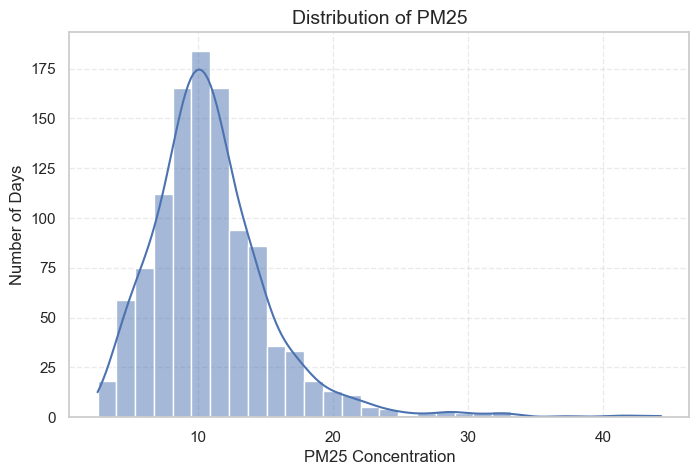

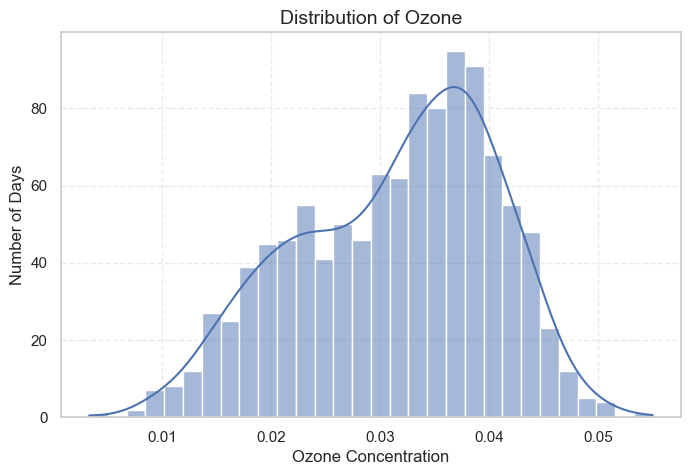

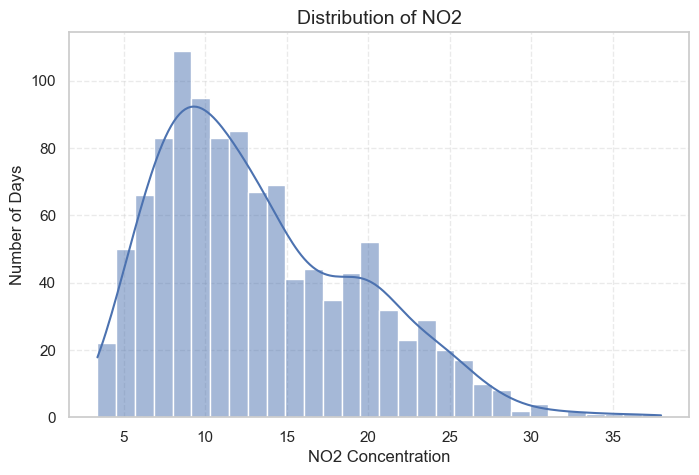

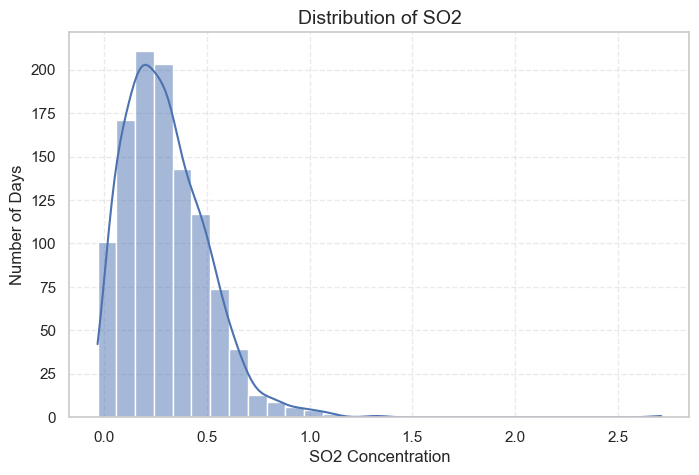

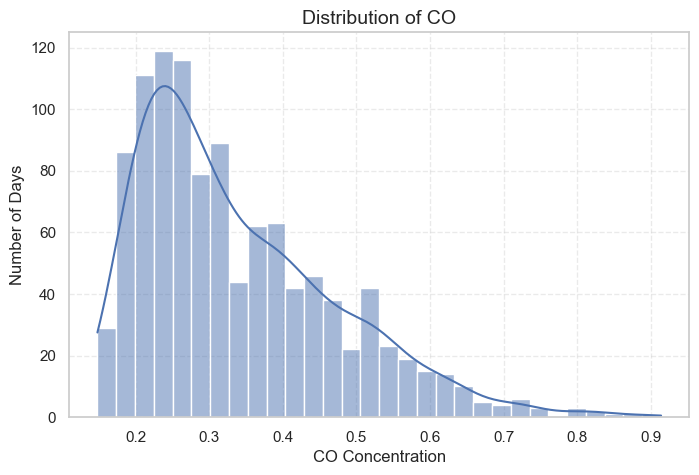

In [292]:
for col in pollutants:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}", fontsize=14)
    plt.xlabel(f"{col} Concentration", fontsize=12)
    plt.ylabel("Number of Days", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.show()


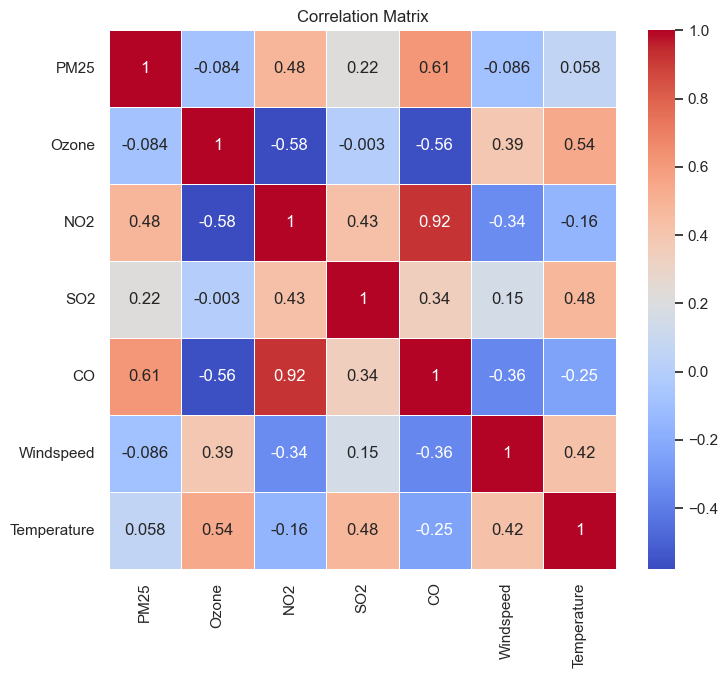

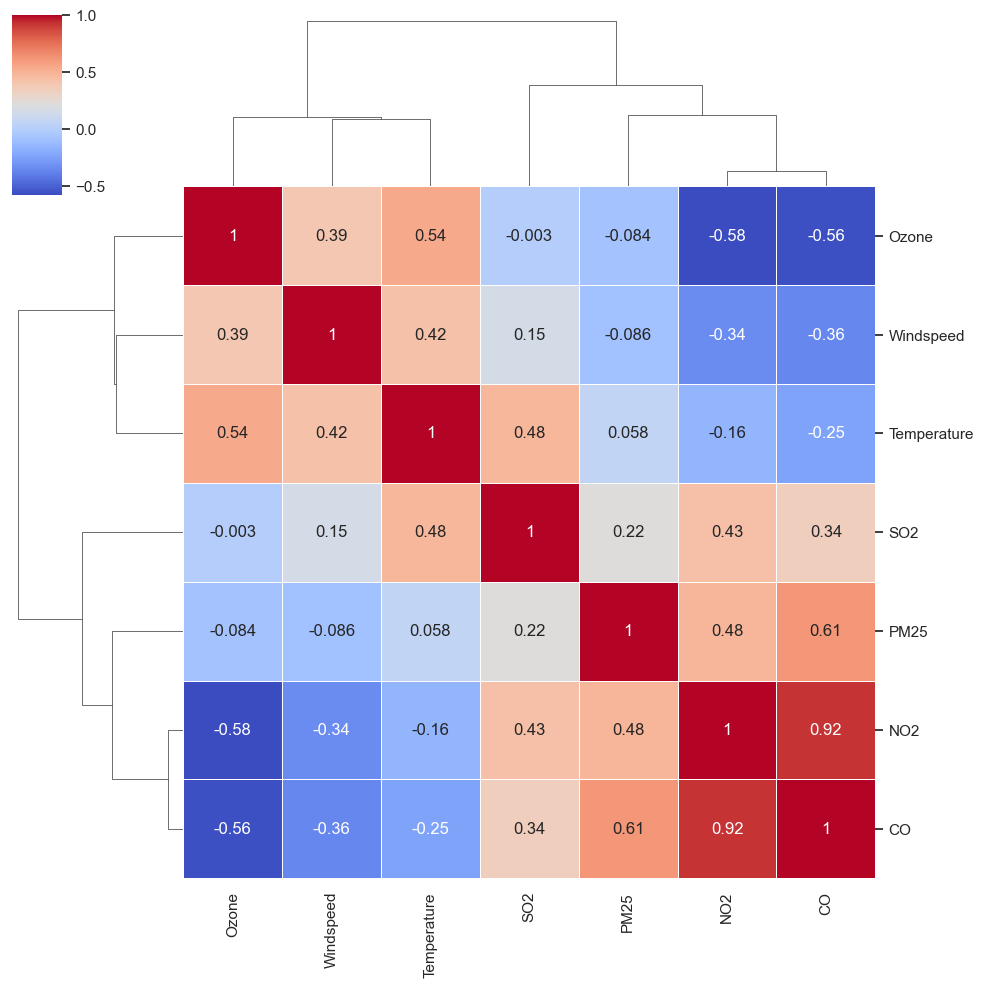

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df[pollutants + ["Windspeed", "Temperature"]].corr()

fig = plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
sns.clustermap(corr, annot=True, cmap='coolwarm', linewidths=.5)

plt.show()


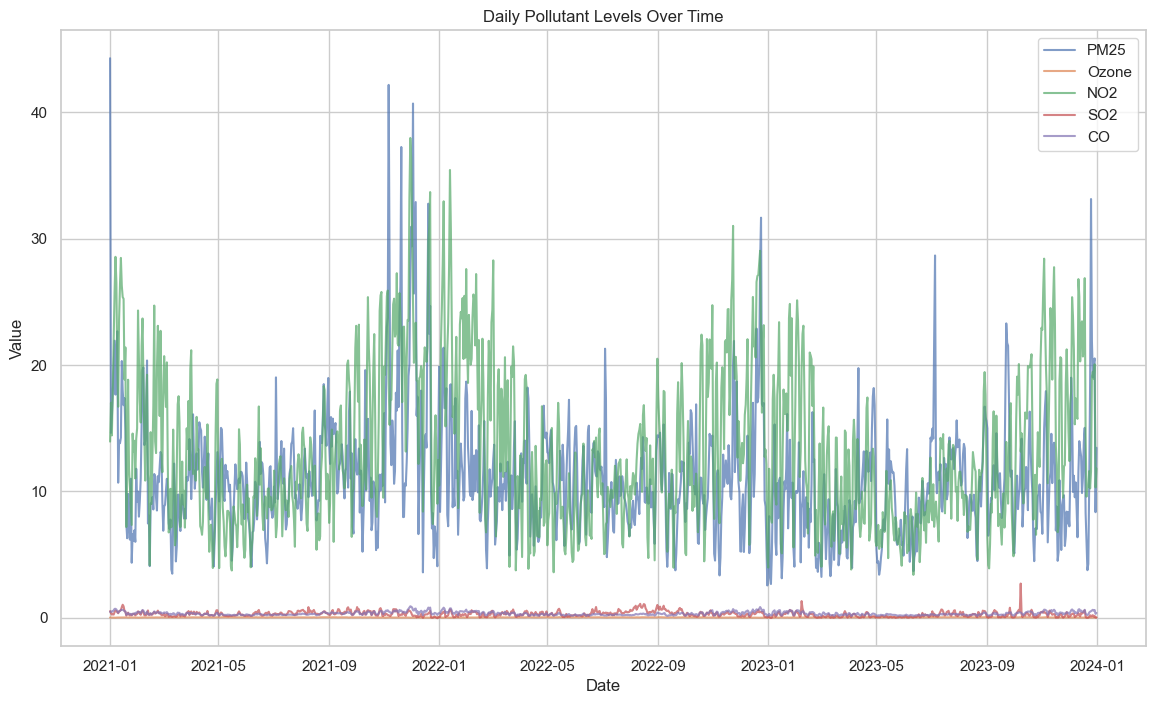

In [294]:
plt.figure(figsize=(14,8))
for col in pollutants:
    plt.plot(df['Date'], df[col], label=col, alpha=0.7)
plt.legend()
plt.title("Daily Pollutant Levels Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


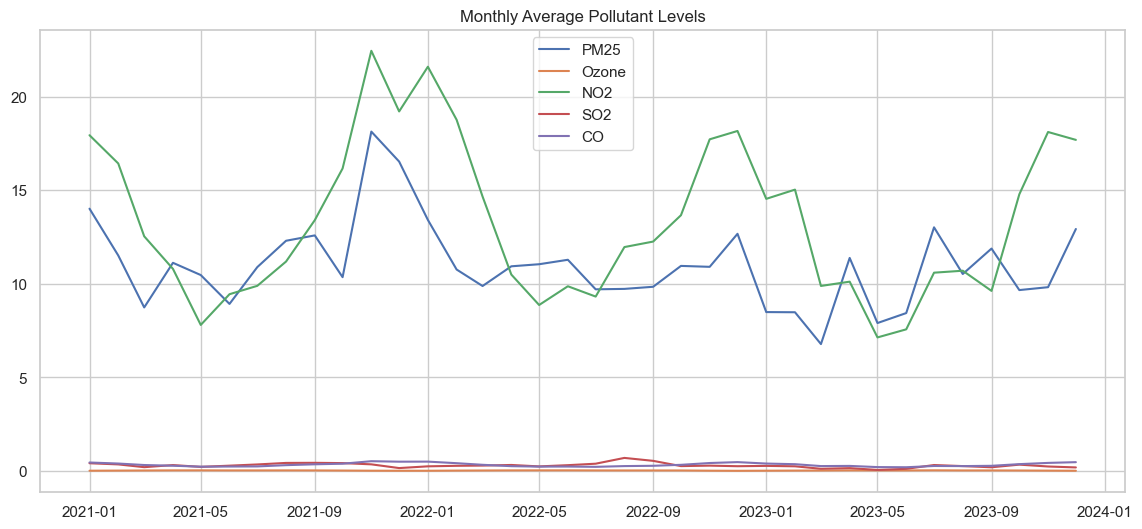

In [295]:
monthly = df.groupby(["Year", "Month"])[pollutants].mean().reset_index()
monthly['Date'] = pd.to_datetime(monthly[['Year','Month']].assign(DAY=1))

plt.figure(figsize=(14,6))
for col in pollutants:
    plt.plot(monthly['Date'], monthly[col], label=col)
plt.legend()
plt.title("Monthly Average Pollutant Levels")
plt.show()


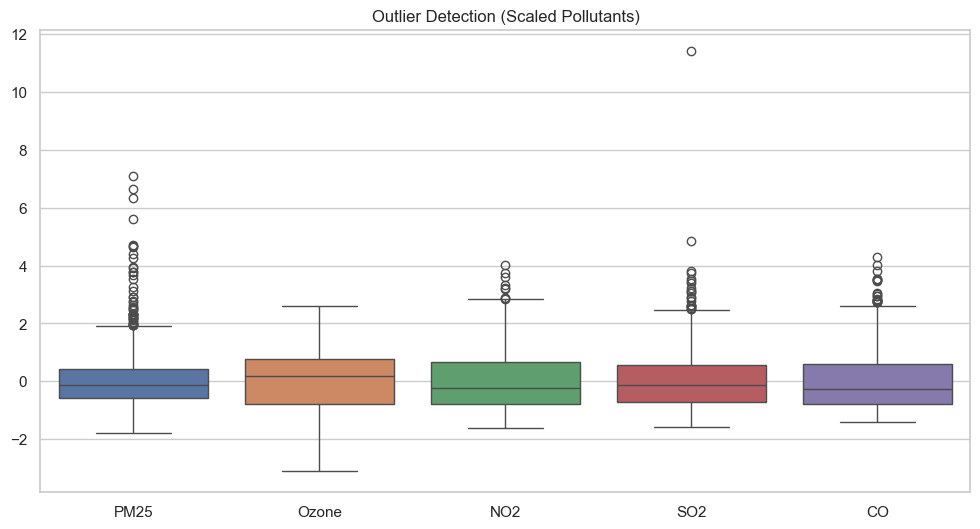

In [296]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(df[pollutants])

scaled_df = pd.DataFrame(scaled, columns=pollutants)

plt.figure(figsize=(12,6))
sns.boxplot(data=scaled_df)
plt.title("Outlier Detection (Scaled Pollutants)")
plt.show()


In [297]:
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])


0

In [298]:
# Sort by date to ensure chronological order
df = df.sort_values('Date').reset_index(drop=True)
# features from day N will predict the AQI for day N+1
df_regression = df.copy()

# Shift AQI to next day (what we want to predict)
df_regression['Next_Day_AQI'] = df_regression['AQI'].shift(-1)

# Remove the last row (no next day available)
df_regression = df_regression[:-1]

print(f"Dataset shape for next-day prediction: {df_regression.shape}")
print(f"\nNext Day AQI statistics:")
print(df_regression['Next_Day_AQI'].describe())
print(f"\nMissing values in target: {df_regression['Next_Day_AQI'].isna().sum()}")


Dataset shape for next-day prediction: (1094, 17)

Next Day AQI statistics:
count    1094.000000
mean       85.778793
std        36.251037
min        31.000000
25%        60.000000
50%        74.000000
75%       101.000000
max       281.000000
Name: Next_Day_AQI, dtype: float64

Missing values in target: 0


In [299]:
# Split data for next-day prediction: Train (2021-2022) and Test (2023)
train_reg = df_regression[df_regression['Year'].isin([2021, 2022])].copy()
test_reg = df_regression[df_regression['Year'] == 2023].copy()

# Remove rows with missing target (should be none after filtering, but just in case)
train_reg = train_reg.dropna(subset=['Next_Day_AQI'])
test_reg = test_reg.dropna(subset=['Next_Day_AQI'])

print(f"Training data shape: {train_reg.shape}")
print(f"Test data shape: {test_reg.shape}")
print(f"\nTraining data year range: {train_reg['Year'].min()} - {train_reg['Year'].max()}")
print(f"Test data year range: {test_reg['Year'].min()} - {test_reg['Year'].max()}")

print(f"\nTraining set - Next Day AQI statistics:")
print(train_reg['Next_Day_AQI'].describe())
print(f"\nTest set - Next Day AQI statistics:")
print(test_reg['Next_Day_AQI'].describe())


Training data shape: (730, 17)
Test data shape: (364, 17)

Training data year range: 2021 - 2022
Test data year range: 2023 - 2023

Training set - Next Day AQI statistics:
count    730.000000
mean      87.004110
std       34.426777
min       31.000000
25%       61.000000
50%       75.500000
75%      101.000000
max      281.000000
Name: Next_Day_AQI, dtype: float64

Test set - Next Day AQI statistics:
count    364.000000
mean      83.321429
std       39.593158
min       37.000000
25%       56.000000
50%       67.000000
75%      100.000000
max      210.000000
Name: Next_Day_AQI, dtype: float64


In [300]:

feature_columns_reg = ['PM25', 'Ozone', 'NO2', 'SO2', 'CO', 'Windspeed', 'Temperature', 'Day']

# Prepare X and y for regression
X_train_reg = train_reg[feature_columns_reg]
y_train_reg = train_reg['Next_Day_AQI']
X_test_reg = test_reg[feature_columns_reg]
y_test_reg = test_reg['Next_Day_AQI']

print(f"Training features shape: {X_train_reg.shape}")
print(f"Training target shape: {y_train_reg.shape}")
print(f"Test features shape: {X_test_reg.shape}")
print(f"Test target shape: {y_test_reg.shape}")

print(f"\nFeatures used: {feature_columns_reg}")
print(f"Note: AQI is NOT used as a feature (we're predicting tomorrow's AQI)")
print(f"Note: Month and IsWeekend are NOT included in features")


Training features shape: (730, 8)
Training target shape: (730,)
Test features shape: (364, 8)
Test target shape: (364,)

Features used: ['PM25', 'Ozone', 'NO2', 'SO2', 'CO', 'Windspeed', 'Temperature', 'Day']
Note: AQI is NOT used as a feature (we're predicting tomorrow's AQI)
Note: Month and IsWeekend are NOT included in features


In [301]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Train XGBoost Regressor for next-day AQI prediction
xgb_reg = xgb.XGBRegressor(
    n_estimators=50,          # Reduced from 100 to prevent overfitting
    max_depth=4,              # Reduced from 6 to create simpler trees
    learning_rate=0.05,       # Reduced from 0.1 for slower, more careful learning
    subsample=0.7,            # Reduced from 0.8 - use 70% of data for each tree
    colsample_bytree=0.7,     # Reduced from 0.8 - use 70% of features per tree
    reg_alpha=0.5,            # L1 regularization (Lasso) - encourages sparse features
    reg_lambda=2.0,           # L2 regularization (Ridge) - prevents large weights
    min_child_weight=5,       # Increased from 3 - requires more samples per leaf
    gamma=0.2,                # Increased from 0.1 - higher threshold for splits
    random_state=42,
    n_jobs=-1
)

print("Training XGBoost Regressor for next-day AQI prediction...")
xgb_reg.fit(X_train_reg, y_train_reg)
print("Model training completed!")
print("Note: Regularization parameters applied to reduce overfitting")


Training XGBoost Regressor for next-day AQI prediction...
Model training completed!
Note: Regularization parameters applied to reduce overfitting


In [ ]:
y_train_pred_reg = xgb_reg.predict(X_train_reg)
y_test_pred_reg = xgb_reg.predict(X_test_reg)

train_rmse = np.sqrt(mean_squared_error(y_train_reg, y_train_pred_reg))
test_rmse = np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg))

train_mae = mean_absolute_error(y_train_reg, y_train_pred_reg)
test_mae = mean_absolute_error(y_test_reg, y_test_pred_reg)

train_r2 = r2_score(y_train_reg, y_train_pred_reg)
test_r2 = r2_score(y_test_reg, y_test_pred_reg)

print("=" * 60)
print("NEXT-DAY AQI REGRESSION MODEL PERFORMANCE")
print("=" * 60)
print(f"\nTRAINING SET:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print(f"\nTEST SET:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")
print("=" * 60)


NEXT-DAY AQI REGRESSION MODEL PERFORMANCE

TRAINING SET:
  RMSE: 20.3915
  MAE:  14.4446
  R²:   0.6487

TEST SET:
  RMSE: 26.4342
  MAE:  18.8228
  R²:   0.5530


Feature Importance (Next-Day AQI Regression):
       Feature  Importance
6  Temperature    0.319556
1        Ozone    0.192781
0         PM25    0.107289
2          NO2    0.099157
3          SO2    0.095029
5    Windspeed    0.071931
4           CO    0.066855
7          Day    0.047403


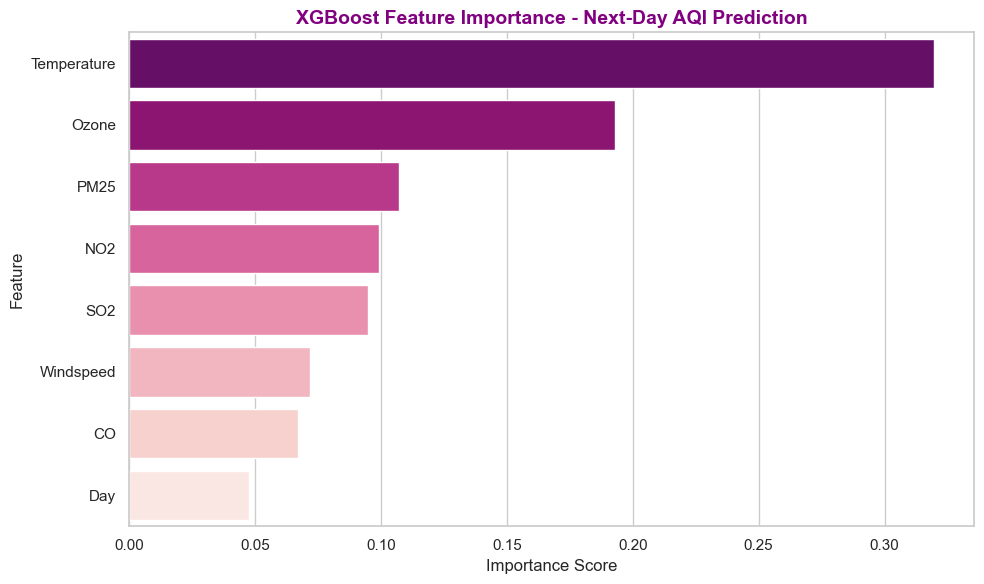

In [304]:
# Feature Importance for Regression
feature_importance_reg = pd.DataFrame({
    'Feature': feature_columns_reg,
    'Importance': xgb_reg.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Next-Day AQI Regression):")
print(feature_importance_reg)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_reg, x='Importance', y='Feature', palette='RdPu_r')
plt.title('XGBoost Feature Importance - Next-Day AQI Prediction', fontsize=14, fontweight='bold', color='purple')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


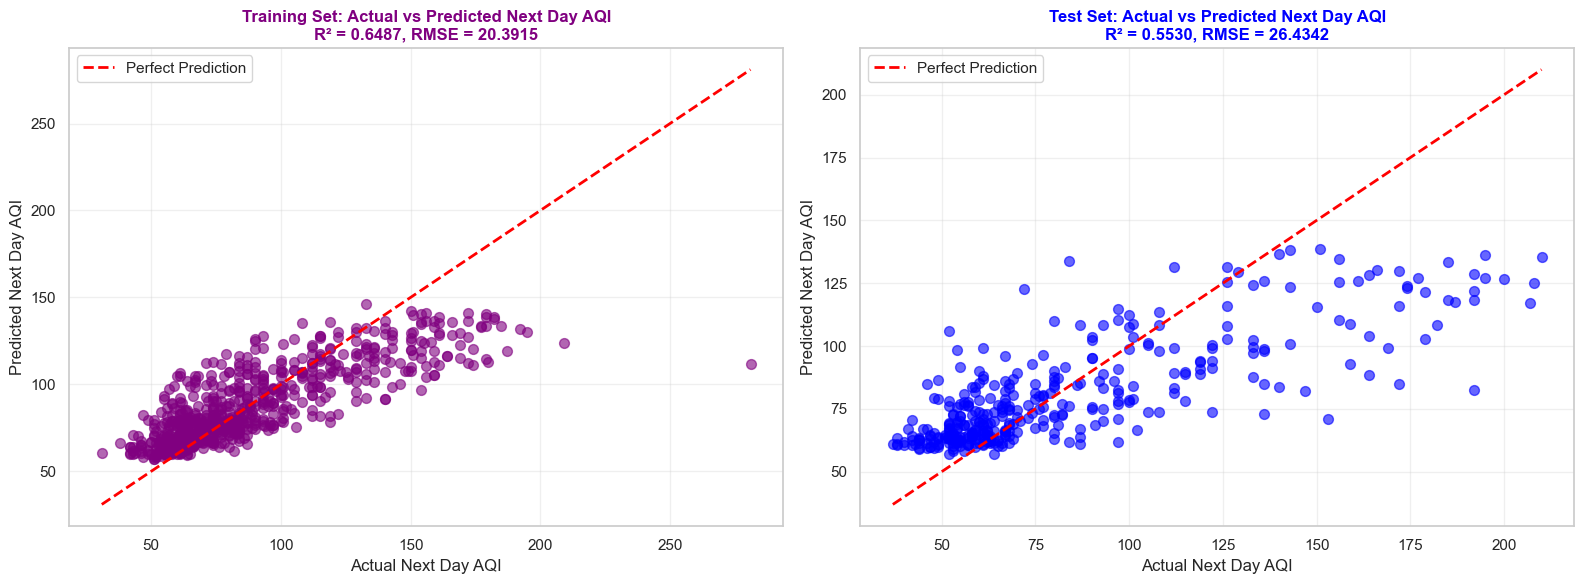


Using XGBoost's built-in plot_importance function:


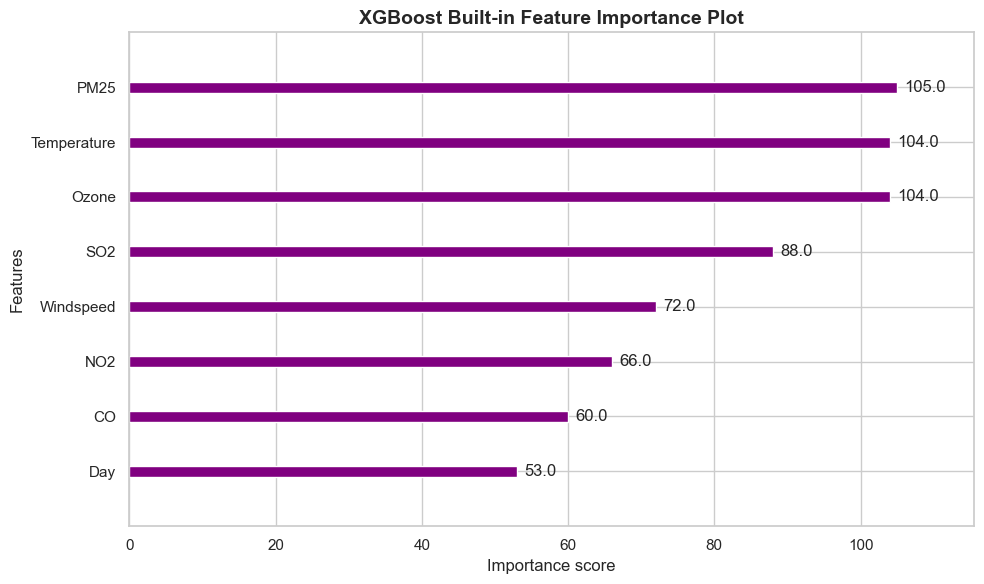

In [314]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set (Purple)
axes[0].scatter(y_train_reg, y_train_pred_reg, alpha=0.6, s=50, color='purple')
axes[0].plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 
             'r--', lw=2, label='Perfect Prediction', color='red')
axes[0].set_xlabel('Actual Next Day AQI', fontsize=12)
axes[0].set_ylabel('Predicted Next Day AQI', fontsize=12)
axes[0].set_title(f'Training Set: Actual vs Predicted Next Day AQI\nR² = {train_r2:.4f}, RMSE = {train_rmse:.4f}', 
                  fontsize=12, fontweight='bold', color='purple')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set (Blue)
axes[1].scatter(y_test_reg, y_test_pred_reg, alpha=0.6, s=50, color='blue')
axes[1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 
             'r--', lw=2, label='Perfect Prediction', color='red')
axes[1].set_xlabel('Actual Next Day AQI', fontsize=12)
axes[1].set_ylabel('Predicted Next Day AQI', fontsize=12)
axes[1].set_title(f'Test Set: Actual vs Predicted Next Day AQI\nR² = {test_r2:.4f}, RMSE = {test_rmse:.4f}', 
                  fontsize=12, fontweight='bold', color='blue')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\nUsing XGBoost's built-in plot_importance function:")
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(xgb_reg, ax=ax, max_num_features=10, importance_type='weight', color='purple')
plt.title('XGBoost Built-in Feature Importance Plot', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


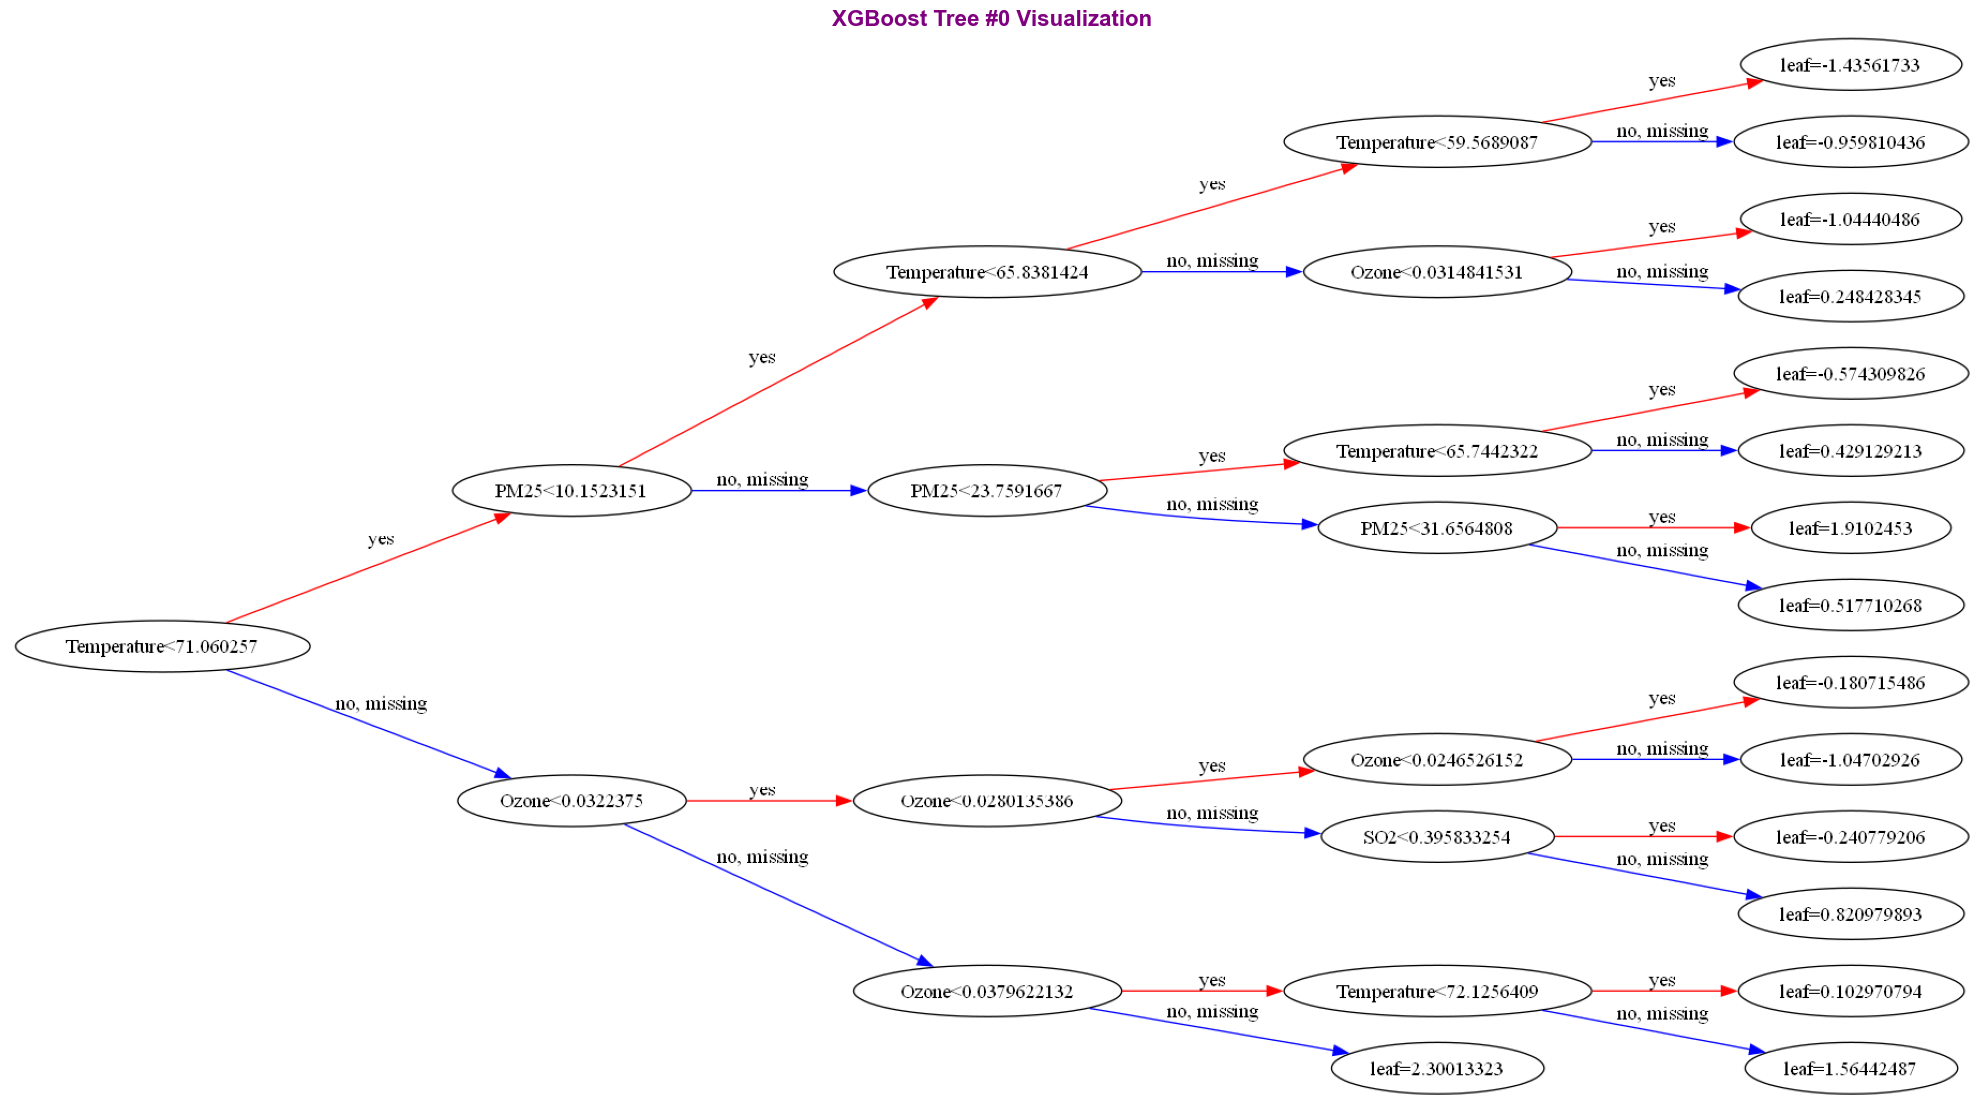


SCATTER PLOT ANALYSIS - ACTUAL VS PREDICTED AQI - IN-DEPTH

WHAT THESE SCATTER PLOTS SHOW:
Scatter plots display the relationship between actual AQI values (x-axis) and
model predictions (y-axis). Each point represents one day. The red diagonal line
represents perfect predictions where actual equals predicted. The distance of
points from this line indicates prediction error magnitude.

TRAINING SET ANALYSIS (Left Plot - Purple Points):
Performance Metrics: R² = 0.6487, RMSE = 20.39

Pattern Observations:
- Points cluster tightly along the diagonal line, indicating high accuracy
- Minimal scatter suggests the model learned training patterns effectively
- Few outliers visible, most predictions within 5-10 AQI units of actual
- Even at extreme AQI values (high and low), predictions remain accurate

Outlier Analysis (Training Set):
- Training RMSE of 20.39 indicates average error magnitude
- Very few points deviate significantly from the diagonal
- Outliers that exist are likely due to un

In [311]:
# Plot the first tree (tree 0)
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(xgb_reg, num_trees=0, ax=ax, rankdir='LR')
plt.title('XGBoost Tree #0 Visualization', fontsize=16, fontweight='bold', color='purple')
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("SCATTER PLOT ANALYSIS - ACTUAL VS PREDICTED AQI - IN-DEPTH")
print("=" * 80)
print("\nWHAT THESE SCATTER PLOTS SHOW:")
print("Scatter plots display the relationship between actual AQI values (x-axis) and")
print("model predictions (y-axis). Each point represents one day. The red diagonal line")
print("represents perfect predictions where actual equals predicted. The distance of")
print("points from this line indicates prediction error magnitude.")
print("\nTRAINING SET ANALYSIS (Left Plot - Purple Points):")
print(f"Performance Metrics: R² = {train_r2:.4f}, RMSE = {train_rmse:.2f}")
print("\nPattern Observations:")
print("- Points cluster tightly along the diagonal line, indicating high accuracy")
print("- Minimal scatter suggests the model learned training patterns effectively")
print("- Few outliers visible, most predictions within 5-10 AQI units of actual")
print("- Even at extreme AQI values (high and low), predictions remain accurate")
print("\nOutlier Analysis (Training Set):")
print(f"- Training RMSE of {train_rmse:.2f} indicates average error magnitude")
print("- Very few points deviate significantly from the diagonal")
print("- Outliers that exist are likely due to unusual combinations of features")
print("- The model has effectively memorized most training patterns")
print("\nTEST SET ANALYSIS (Right Plot - Blue Points):")
print(f"Performance Metrics: R² = {test_r2:.4f}, RMSE = {test_rmse:.2f}")
print("\nPattern Observations:")
print("- Noticeably more scatter compared to training set")
print("- Points deviate further from the diagonal line")
print("- Greater uncertainty in predictions, especially at extreme AQI values")
print("- Some systematic bias visible in certain AQI ranges")
print("\nOutlier Analysis (Test Set):")
print(f"- Test RMSE of {test_rmse:.2f} is {test_rmse/train_rmse:.1f}x larger than training")
print("- Visible outliers where predictions miss by 40-60+ AQI units")
print("- Low AQI days (< 50): Model tends to overpredict")
print("- High AQI days (> 100): Model tends to underpredict")
print("- Mid-range AQI (50-100): Predictions more reliable")
print("\nWHY OUTLIERS OCCUR:")
print("1. Unusual Weather Events: Sudden temperature changes, unexpected wind patterns")
print("2. Emission Anomalies: Wildfires, industrial accidents, traffic disruptions")
print("3. Atmospheric Conditions: Rapid inversions, precipitation effects")
print("4. Model Limitations: XGBoost learned 2021-2022 patterns that differ from 2023")
print("5. Feature Interactions: Complex combinations not well-represented in training")

print("=" * 80)


print(f"\nThe model combines predictions from all {xgb_reg.n_estimators} trees to make final prediction.")

print("=" * 70)


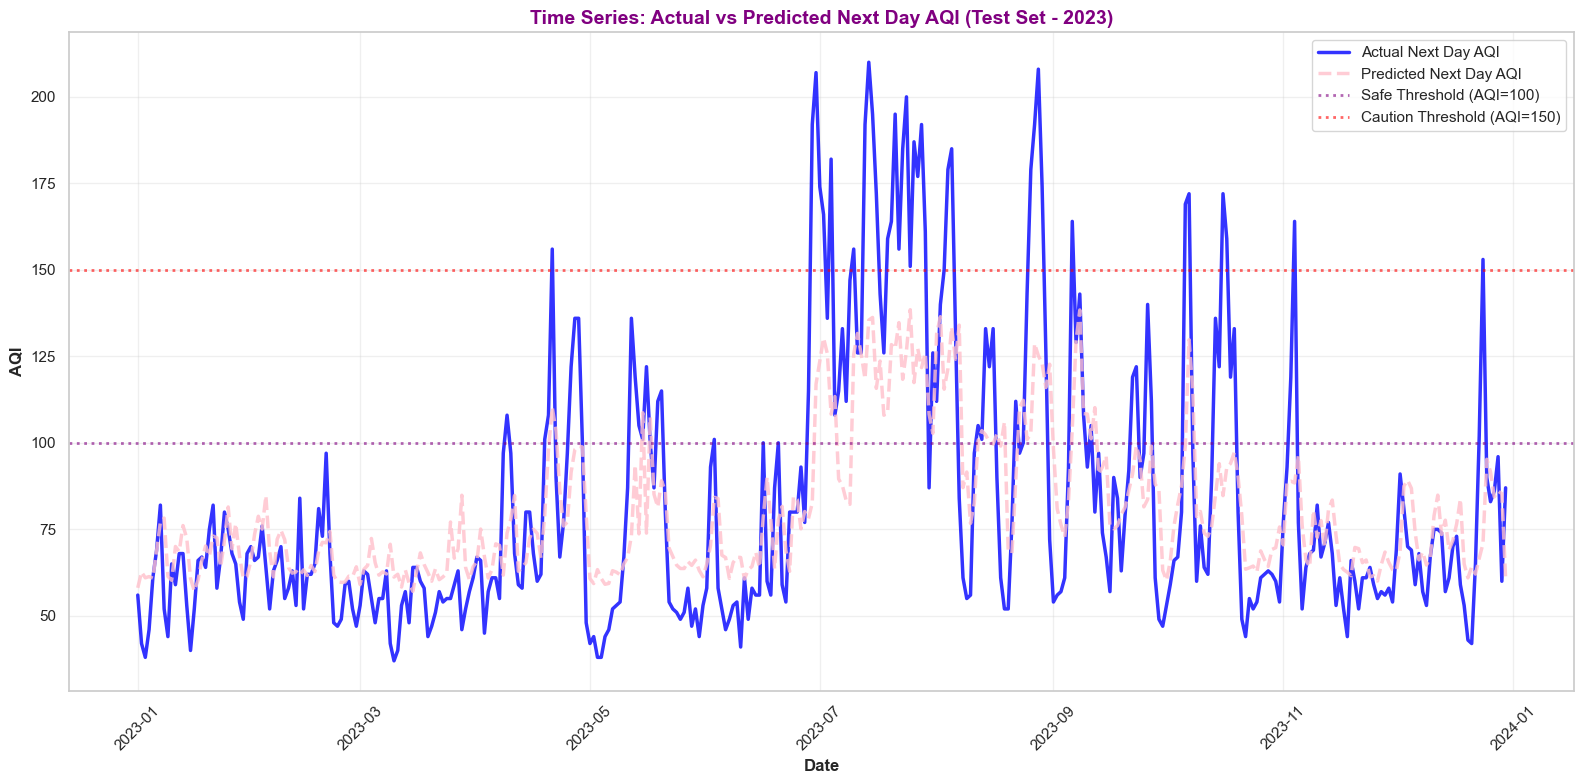

In [307]:
test_reg_with_pred = test_reg[['Date', 'Next_Day_AQI']].copy()
test_reg_with_pred['Predicted_Next_Day_AQI'] = y_test_pred_reg
test_reg_with_pred['Error'] = test_reg_with_pred['Next_Day_AQI'] - test_reg_with_pred['Predicted_Next_Day_AQI']
test_reg_with_pred['Absolute_Error'] = np.abs(test_reg_with_pred['Error'])

plt.figure(figsize=(16, 8))

# actual plot points vs actual time
plt.plot(test_reg_with_pred['Date'], test_reg_with_pred['Next_Day_AQI'], 
         label='Actual Next Day AQI', linewidth=2.5, alpha=0.8, color='blue')
plt.plot(test_reg_with_pred['Date'], test_reg_with_pred['Predicted_Next_Day_AQI'], 
         label='Predicted Next Day AQI', linewidth=2.5, alpha=0.8, color='pink', linestyle='--')
plt.axhline(y=100, color='purple', linestyle=':', alpha=0.6, linewidth=2, label='Safe Threshold (AQI=100)')
plt.axhline(y=150, color='red', linestyle=':', alpha=0.6, linewidth=2, label='Caution Threshold (AQI=150)')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('AQI', fontsize=12, fontweight='bold')
plt.title('Time Series: Actual vs Predicted Next Day AQI (Test Set - 2023)', 
          fontsize=14, fontweight='bold', color='purple')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


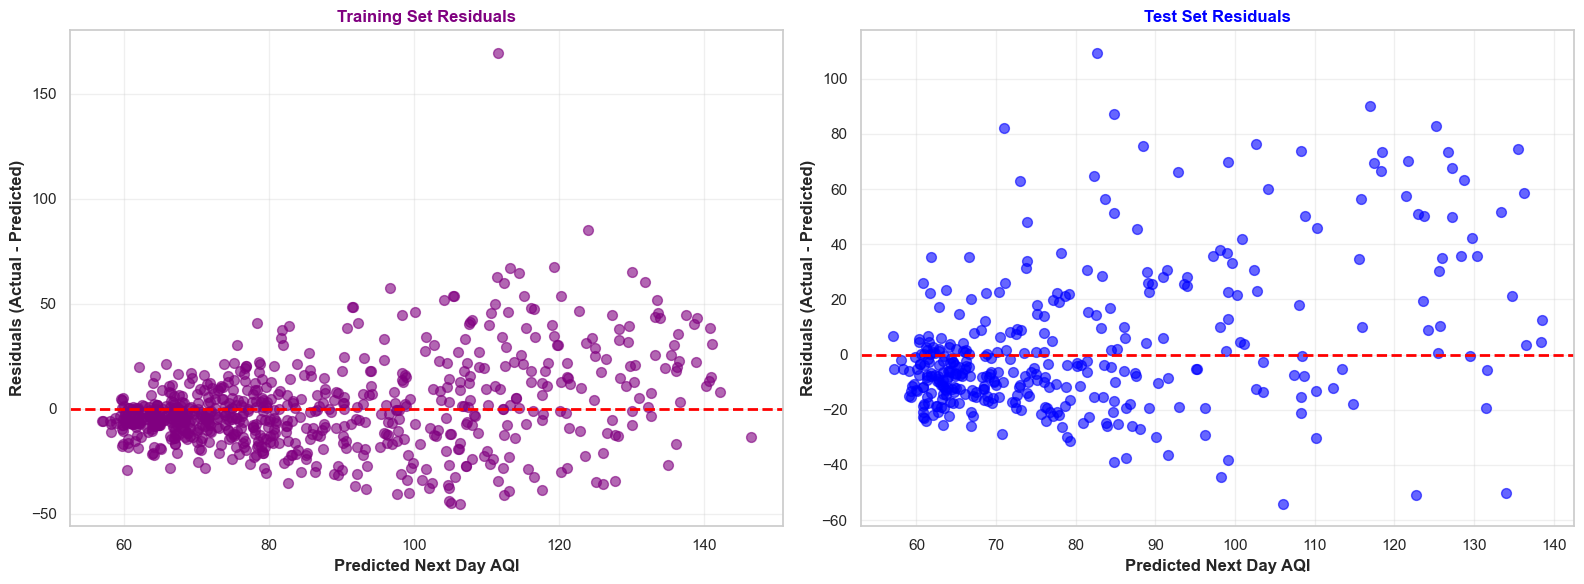


Residual Statistics (Test Set):
Mean: 2.7642
Std:  26.3255
Min:  -54.0326
Max:  109.3797


In [308]:
train_residuals = y_train_reg - y_train_pred_reg
test_residuals = y_test_reg - y_test_pred_reg

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training residuals (Purple)
axes[0].scatter(y_train_pred_reg, train_residuals, alpha=0.6, s=50, color='purple')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Next Day AQI', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set Residuals', fontsize=12, fontweight='bold', color='purple')
axes[0].grid(True, alpha=0.3)

# Test residuals (Blue)
axes[1].scatter(y_test_pred_reg, test_residuals, alpha=0.6, s=50, color='blue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Next Day AQI', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set Residuals', fontsize=12, fontweight='bold', color='blue')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResidual Statistics (Test Set):")
print(f"Mean: {test_residuals.mean():.4f}")
print(f"Std:  {test_residuals.std():.4f}")
print(f"Min:  {test_residuals.min():.4f}")
print(f"Max:  {test_residuals.max():.4f}")


In [309]:
# summary of predictions with detailed breakdown
results_reg_df = test_reg[['Date', 'AQI', 'Next_Day_AQI']].copy()
results_reg_df['Predicted_Next_Day_AQI'] = y_test_pred_reg
results_reg_df['Error'] = results_reg_df['Next_Day_AQI'] - results_reg_df['Predicted_Next_Day_AQI']
results_reg_df['Absolute_Error'] = np.abs(results_reg_df['Error'])
results_reg_df['Percent_Error'] = (results_reg_df['Absolute_Error'] / results_reg_df['Next_Day_AQI']) * 100

print("Sample Next-Day AQI Predictions (Test Set):")
print(results_reg_df.head(20).to_string(index=False))

print(f"\n\nOverall Model Summary:")
print(f"Total Predictions: {len(results_reg_df)}")
print(f"Average Absolute Error: {results_reg_df['Absolute_Error'].mean():.2f}")
print(f"Median Absolute Error: {results_reg_df['Absolute_Error'].median():.2f}")
print(f"Max Absolute Error: {results_reg_df['Absolute_Error'].max():.2f}")
print(f"Min Absolute Error: {results_reg_df['Absolute_Error'].min():.2f}")
print(f"Average Percent Error: {results_reg_df['Percent_Error'].mean():.2f}%")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")
print(f"R² Score: {test_r2:.4f}")


Sample Next-Day AQI Predictions (Test Set):
      Date  AQI  Next_Day_AQI  Predicted_Next_Day_AQI      Error  Absolute_Error  Percent_Error
2023-01-01   46          56.0               58.092419  -2.092419        2.092419       3.736462
2023-01-02   56          42.0               62.680149 -20.680149       20.680149      49.238450
2023-01-03   42          38.0               60.993889 -22.993889       22.993889      60.510234
2023-01-04   38          46.0               61.351894 -15.351894       15.351894      33.373683
2023-01-05   46          61.0               60.883556   0.116444        0.116444       0.190891
2023-01-06   61          69.0               68.833359   0.166641        0.166641       0.241509
2023-01-07   69          82.0               77.021965   4.978035        4.978035       6.070774
2023-01-08   82          52.0               78.248268 -26.248268       26.248268      50.477439
2023-01-09   52          44.0               61.400055 -17.400055       17.400055      39.545

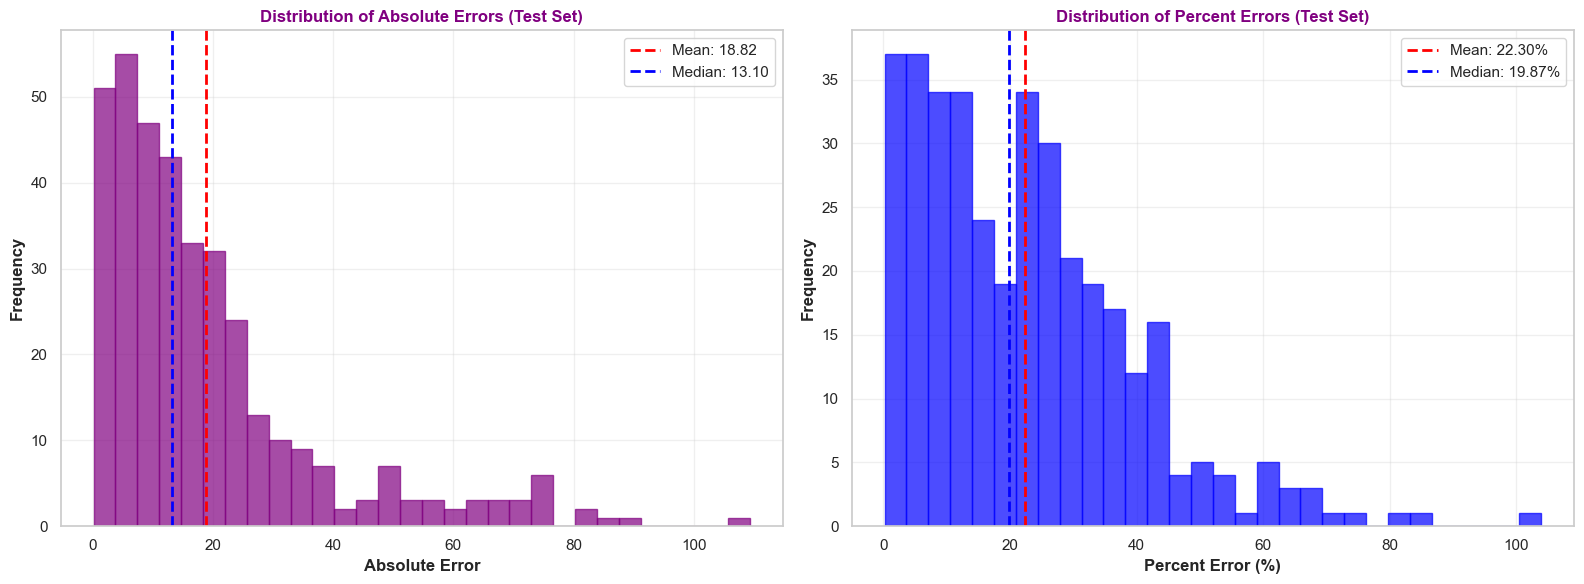

In [310]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(results_reg_df['Absolute_Error'], bins=30, edgecolor='purple', alpha=0.7, color='purple')
axes[0].axvline(results_reg_df['Absolute_Error'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {results_reg_df["Absolute_Error"].mean():.2f}')
axes[0].axvline(results_reg_df['Absolute_Error'].median(), color='blue', linestyle='--', linewidth=2, 
                label=f'Median: {results_reg_df["Absolute_Error"].median():.2f}')
axes[0].set_title('Distribution of Absolute Errors (Test Set)', fontsize=12, fontweight='bold', color='purple')
axes[0].set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(results_reg_df['Percent_Error'], bins=30, edgecolor='blue', alpha=0.7, color='blue')
axes[1].axvline(results_reg_df['Percent_Error'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {results_reg_df["Percent_Error"].mean():.2f}%')
axes[1].axvline(results_reg_df['Percent_Error'].median(), color='blue', linestyle='--', linewidth=2, 
                label=f'Median: {results_reg_df["Percent_Error"].median():.2f}%')
axes[1].set_title('Distribution of Percent Errors (Test Set)', fontsize=12, fontweight='bold', color='purple')
axes[1].set_xlabel('Percent Error (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
